In [1]:
import sys
sys.path.insert(1, '../../SyMBac/')

from SyMBac.drawing import raster_cell
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
import os
from joblib import Parallel, delayed
from skimage.transform import rotate
from SyMBac.PSF import Camera
from numba import njit
import matplotlib.pyplot as plt

In [2]:
@njit
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness) + centreline - int(np.ceil(thickness ))

@njit
def rounder(x):
    out = np.empty_like(x)
    np.round(x, 0, out)
    return out

@njit
def gen_3D_coords_from_2D(test_cells, centreline, thickness):
    return np.where(test_cells == thickness) + (generate_deviation_from_CL(centreline, thickness),)

@njit
def convert_to_3D_numba(cell):
    expanded_scene = cell
    volume_shape = expanded_scene.shape[0:] + (int(expanded_scene.max()*2),)
    test_cells = rounder(expanded_scene)
    centreline = int(expanded_scene.max() )
    cells_3D = np.zeros(volume_shape,dtype = np.ubyte)
    for t in range(int(expanded_scene.max() *2 )):
        test_coords = gen_3D_coords_from_2D(test_cells, centreline, t)
        for x, y in zip(test_coords[0], (test_coords[1])):
            for z in test_coords[2]:
                cells_3D[x, y, z] = 1
    return cells_3D

def convert_to_3D(cell):
    cells_3D = convert_to_3D_numba(cell)
    cells_3D = np.moveaxis(cells_3D, -1, 0)
    cells_3D[cells_3D.shape[0]//2:,:, :] = cells_3D[:cells_3D.shape[0]//2,:, :][::-1]
    return cells_3D
    #cells_3D = np.pad(cells_3D, ((100,100), (50,50), (50,50)))
#cells_3D.shape

def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount = False):


    membrane_thickness = 0.075 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, separation=0)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, separation=0)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

In [7]:
pix_mic_conv = 0.05/2
resize_amount = 1

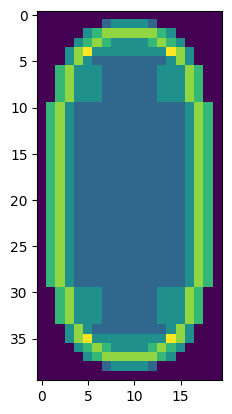

In [9]:
plt.imshow(raster_membrane_cell_3d(1/pix_mic_conv,0.5/pix_mic_conv).sum(axis=0))

In [2]:
pad_amount = 200

radius = 150
wavelength = 0.6
NA = 1.45
n = 1.518
resize_amount = 1
pix_scaler = 1
pix_mic_conv = 0.065 / pix_scaler
apo_sigma = 11

FL_PSF = PSF_generator(
    radius = radius,
    wavelength = wavelength,
    NA = NA,
    n = n,
    resize_amount = resize_amount,
    pix_mic_conv = pix_mic_conv,
    apo_sigma = apo_sigma,
    mode="3d fluo",
    condenser = "Ph3",
    z_height = 22, 
    pz = 0.5,
    working_distance=170
)
FL_PSF.calculate_PSF()
FL_PSF.kernel = np.sum(FL_PSF.kernel, axis=0)

In [3]:
def generate_agar_pad_image(border, img_size, density, iter_threshold, min_length, max_length, min_width, max_width):
    image = np.zeros((int(img_size*pix_scaler * border), int(img_size*pix_scaler * border)))
    mask = np.zeros((int(img_size*pix_scaler * border), int(img_size*pix_scaler * border)))
    mask_labaled = np.zeros((int(img_size*pix_scaler * border), int(img_size*pix_scaler * border))).astype(np.uint)
     #DENSITY In cells per square micron
    n_cells = int(density * ((pix_mic_conv * img_size) ** 2))
    mask_counter = 0
    iterations = 0
    stop_condition = int(n_cells*iter_threshold)
    #pbar = tqdm(total=stop_condition)
    cell_info = []
    while (mask_counter != n_cells) and (iterations != stop_condition):

        cell_length = np.random.uniform(min_length, max_length)
        cell_width = np.random.uniform(min_width, max_width)

        raster_cell_length = cell_length/pix_mic_conv * resize_amount
        raster_cell_width = cell_width/pix_mic_conv * resize_amount

        cell = raster_cell(length=raster_cell_length, width=raster_cell_width, separation=0)
        cell = rotate(cell, angle=np.random.uniform(0,365), resize=True, order = 0, preserve_range = True)
        cell *= int(np.random.uniform(1300,1400))
        #

        cell = cell.astype(int)
        cell_mask = cell > 0
        pos_x_start = int(np.random.uniform(0, image.shape[1] - cell.shape[1]))
        pos_y_start = int(np.random.uniform(0, image.shape[0] - cell.shape[0]))
        if mask[pos_y_start + cell.shape[0]//2, pos_x_start + cell.shape[1]//2]:
            pass
        else:

            mask[pos_y_start:pos_y_start+cell.shape[0], pos_x_start:pos_x_start+cell.shape[1]] += cell_mask
            if np.sum(mask > 1) > 0:
                mask[pos_y_start:pos_y_start+cell.shape[0], pos_x_start:pos_x_start+cell.shape[1]] -= cell_mask
            else:
                image[pos_y_start:pos_y_start+cell.shape[0], pos_x_start:pos_x_start+cell.shape[1]] += cell
                mask_labaled[pos_y_start:pos_y_start+cell.shape[0], pos_x_start:pos_x_start+cell.shape[1]] += (cell_mask * mask_counter).astype(np.uint)
                cell_info.append([mask_counter, cell_length, cell_width])
                mask_counter += 1
                
        iterations += 1
        #pbar.update(1)
    #pbar.close()

    return image, mask_labaled, cell_info

In [4]:
densities = [0.15]*200 #fix the density of FPs in cells this time

In [5]:
try:
    os.mkdir("data")
except:
    pass
min_max_cell_length = [ (1.5,3), (2,4), (3,6), (4,8), (5,10), (6,12) ]
min_max_cell_width = [ (0.7,0.7), (0.8,0.8), (0.9,0.9), (1,1), (1.1,1.1), (1.2,1.2) ]


In [6]:
list(zip(min_max_cell_length, min_max_cell_width))

[((1.5, 3), (0.7, 0.7)),
 ((2, 4), (0.8, 0.8)),
 ((3, 6), (0.9, 0.9)),
 ((4, 8), (1, 1)),
 ((5, 10), (1.1, 1.1)),
 ((6, 12), (1.2, 1.2))]

In [7]:
for (min_length, max_length), (min_width, max_width) in zip(min_max_cell_length, min_max_cell_width):
    try:
        os.mkdir(f"data/")
    except:
        pass
    try:
        os.mkdir(f"data/{min_length}_{max_length}")
    except:
        pass
    try:
        os.mkdir(f"data/{min_length}_{max_length}/training_data")
    except:
        pass
    try:
        os.mkdir(f"data/{min_length}_{max_length}/test_data")
    except:
        pass
    try:
        os.mkdir(f"data/{min_length}_{max_length}/raw_train")
    except:
        pass
    try:
        os.mkdir(f"data/{min_length}_{max_length}/raw_test")
    except:
        pass
    img_mask_pairs = Parallel(n_jobs=-1)(delayed(generate_agar_pad_image)(1, 800, density, 2, min_length, max_length, min_width, max_width) for density in tqdm(densities))

    
    conv_imgs = []
    for a, (image, mask, cell_info) in enumerate(tqdm(img_mask_pairs)):
        my_camera = Camera(baseline=100, sensitivity=2.9, dark_noise=8)
        dark_image = my_camera.render_dark_image(size=image.shape, plot=False);
        conv_image = convolve_rescale(image, FL_PSF.kernel, rescale_factor=1/pix_scaler, rescale_int=True)
        conv_image = (dark_image + conv_image * 1000)
        conv_image /= conv_image.max()
        if a < 20:
            Image.fromarray(img_as_uint(conv_image/conv_image.max())).save(f"data/{min_length}_{max_length}/training_data/{str(a).zfill(4)}.png")
            Image.fromarray(img_as_uint(mask)).save(f"data/{min_length}_{max_length}/training_data/{str(a).zfill(4)}_masks.png")
            Image.fromarray(img_as_uint(image/image.max())).save(f"data/{min_length}_{max_length}/raw_train/{str(a).zfill(4)}.png")
        else:
            Image.fromarray(img_as_uint(conv_image/conv_image.max())).save(f"data/{min_length}_{max_length}/test_data/{str(a).zfill(4)}.png")
            Image.fromarray(img_as_uint(mask)).save(f"data/{min_length}_{max_length}/test_data/{str(a).zfill(4)}_masks.png")
            Image.fromarray(img_as_uint(image/image.max())).save(f"data/{min_length}_{max_length}/raw_test/{str(a).zfill(4)}.png")

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 404 fits in uint16
  return _convert(image, np.uint16, force_copy)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 325 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 334 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 321 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 324 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 204 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 201 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 197 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 214 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 142 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 146 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 138 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 140 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 100 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 106 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 102 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 104 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 78 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 84 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 91 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skimage/util/dtype.py:501: UserWarning: Downcasting uint64 to uint16 without scaling because max value 80 fits in uint16
  return _convert(image, np.uint16, force_copy)
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/skim